# Bag the Models with Bagging

The **combination of classifiers can help reduce misclassification errors substantially**. Many studies have proved such ensembling methods can **significantly reduce the variance of the prediction model**. Several techniques have been proposed to achieve a variance reduction. For example, in many cases, bootstrap aggregating (bagging) classification trees have been shown to have higher accuracy than a single classification tree. **Bagging can be applied to tree-based algorithms to enhance the accuracy of the predictions**, although it can be used with methods other than tree-based methods as well.

## Bootstrap aggregation

**Bootstrap aggregation**, also known as **bagging**, is a powerful ensemble method that was proposed by Leo Breiman in 1994 **to prevent overfitting**. **The concept behind *bagging* is to combine the predictions of several base learners to create a more accurate output.**

Breiman showed that **bagging can successfully achieve the desired result in unstable learning algorithms where small changes to the training data can lead to large variations in the predictions**. Breiman demonstrated that algorithms such as neural networks and decision trees are examples of unstable learning algorithms. Bootstrap aggregation is effective on small datasets.

The general procedure for bagging helps to reduce variance for those algorithms have high variance. Bagging also supports the classification and regression problem. The following diagram shows how the bootstrap aggregation flow works:
![Alt text](bagging.png)

Using bootstrapping with a training dataset X, we generate N bootstrap samples X1, X2,....., XN.

For each bootstrap sample, we train a classifier, $b_i(x)$. The combined classifier will average the outputs from all these individual classifiers as follows:

$$
b(x) = \frac{1}{N}\sum^N_{i=1}b_i(x)
$$

In the preceding formula, $N$ represents the number of samples.

In a **bagging classifier**, **voting is used to make a final prediction**. The pseudo-code for the bagging classifier proposed by Breiman is as follows:

![Alt text](bagging_classifier.png)

In the case of the **bagging regressor**, **the final prediction is the average of the predictions of the models that are built over each bootstrap sample**. The following pseudo-code describes the bagging regressor:

![Alt text](bagging_regressor.png)

### Getting ready

We start by importing the required libraries and reading our file. We suppress any warnings using the `warnings.filterwarnings()` function from the `warnings` library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

import matplotlib.pyplot as plt

df_autodata = pd.read_csv("autompg.csv")

# We check wether the dataset has any missing values as follows
# the below syntax returns the columns names which has any missing value
columns_with_missing_values = df_autodata.columns[df_autodata.isnull().any()]

# We pass the column names with missing values to the dataframe to count the number
# of missing values
df_autodata[columns_with_missing_values].isnull().sum()

horsepower    6
dtype: int64

In [2]:
# We notice that the horsepower variable has six missing values. We can fill in the missing values using the median of the horsepower variable's existing values with the following code:
df_autodata['horsepower'].fillna(df_autodata['horsepower'].median(), inplace=True)
# We notice that the carname variable is an identifier and is not useful in our model-building exercise, so we can drop it as follows:

df_autodata.drop(['carname'], axis=1, inplace=True)
# We can look at the data with the dataframe.head() command:

df_autodata.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


### How to do it

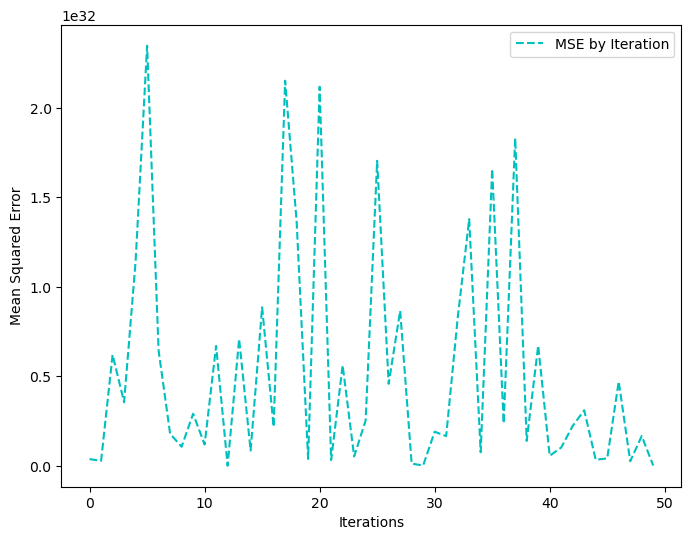

In [3]:
# 1 We start by creating the bootstrap samples
# In Chapter 3, Resampling Methods, we wrote a
# custom function, create_bootstrap_oob(), to
# create both bootstrap and out-of-bag (OOB) samples.

def create_bootstrap_oob(df):
    global df_OOB
    global df_bootstrap_sample 
    # creating the bootstrap sample
    df_bootstrap_sample = resample(df, replace=True, n_samples=100)
    
    # creating the OOB sample 
    bootstrap_sample_index = tuple(df_bootstrap_sample.index)
    bootstrap_df = df.index.isin(bootstrap_sample_index)
    
    df_OOB = df[~bootstrap_df]

# 2 We build models using the bootstrap samples and average
# the cost function across all the models. We use the SGDRegressor()
# on each bootstrap sample. In the following code block, we reuse
# our previously written custom function, create_bootstrap_oob(),
# to create the bootstrap and OOB error samples:
iteration=50
mse_each_iterations = list()
lm=SGDRegressor()
total_mse=0
average_mse= list()

for i in range(iteration):
    create_bootstrap_oob(df_autodata)

    # Bootstrap sample features set
    X_BS = df_bootstrap_sample.iloc[:,1:8] 

    # bootstrap sample response variable
    Y_BS = df_bootstrap_sample.iloc[:,0]
    X_OOB = df_OOB.iloc[:,1:8] #OOB sample features
    Y_OOB = df_OOB.iloc[:,0] #OOB sample response variable 
    
    # fit your model with bootstrap sample
    lm=SGDRegressor()
    lm.fit(X_BS, Y_BS)
    
    # test your model on out-of-bag sample 
    predictedvalues = lm.predict(X_OOB)
    
    # capture MSE for the predicted values against OOB actuals
    mse = mean_squared_error(Y_OOB, predictedvalues)
    
    # create a list of mse values
    mse_each_iterations.append(mse)

# 3 We are now going to plot the MSE for each model built:
import matplotlib.pyplot as plt
f, ax= plt.subplots(figsize=(8,6))

plt.plot(mse_each_iterations, 'c--', label='MSE by Iteration')

plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.legend(loc=1)
plt.show()

### How it works

In Step 1, we executed our custom function code to create the `create_bootstrap_oob()` function that creates the bootstrap and `OOB samples` for us. In Step 2, we executed the following steps:

1. We decided to make $50$ iterations, so we set the iteration variable to 50.
2. The `create_bootstrap_oob()` function returned two DataFrame objects, df_bootstrap_sample and df_OOB, in each iteration.
3. We used `df_bootstrap_sample` and `df_OOB` as our bootstrap and OOB samples respectively.
4. We split both the df_bootstrap_sample and the `df_OOB` samples into feature sets and response variables.
5. We fit the `SGDRegressor()` to our bootstrap sample to build our model.
6. We passed the `OOB sample` to the model to predict our values.
7. We compared the predicted values against the response variable in the OOB sample.
8. We calculated the `MSE` for each iteration.

In Step 3, we created a plot to show the MSE for each iteration up to the fiftieth iteration. This result may vary because of randomness.

## Ensemble meta-estimators

The **bagging classifier and the bagging regressor are ensemble meta-estimators** that **fit the base classifier and regressor models respectively on random subsets of the original dataset**. The **predictions from each model are combined to create the final prediction**. These kinds of meta-estimators induce randomization into the model-building process and aggregate the outcome. **The aggregation averages over the iterations for a numerical target variable and performs a plurality vote in order to reach a categorical outcome**.

## Bagging classifiers

Bagging classifiers train each classifier model on a random subset of the original training set and aggregate the predictions, then perform a plurality voting for a categorical outcome. In the following recipe, we are going to look at an implementation of a bagging classifier with bootstrap samples.

### How to do it

In [6]:
# 1 We import BaggingClassifier and DecisionTreeClassifier from
# scikit-learn
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# 2 Next we read out the data and take a look at the dim
df_winedata = pd.read_csv('./winedata.csv')
df_winedata.shape

(177, 14)

In [7]:
# 3 We separate our features and the response set. We also split
# out data into train test subsets
X = df_winedata.iloc[:, 1: 14]
y = df_winedata.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# 4 We create an instance of the DecisionTreeClassifier class and pass
# it to the BagginClassifier()
dt_model = DecisionTreeClassifier(criterion='entropy')
bag_dt_model = BaggingClassifier(dt_model, max_features=1.0, n_estimators=5, \
                            random_state=1, bootstrap=True)

# Note that in the preceding code block, we have declared bootstrap=True. 
# This is the default value and indicates that samples are drawn with replacement.

# 5 We fit our model to the training data as follows
bag_dt_model.fit(X_train, y_train)

# 6 We can see the score after passing the test data to the model
bag_dt_model.score(X_test, y_test)

# 7 We use the predict function to predict the response variable as follows
predictedvalues = bag_dt_model.predict(X_test)

In [8]:
# 8 e will now use a code to plot the confusion matrix. Note that this code has been taken from scikit-learn.org. We execute the following code to create the plot_confusion_matrix() function:
# code from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actuals')
    plt.xlabel('Predicted')

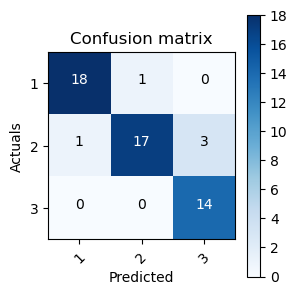

In [9]:
# 9 We use the preceding plot_confusion_matrix() function to plot our confusion matrix:
# This variable holds the class labels of our target variable
target_names = [ '1', '2', '3']

import itertools
from sklearn.metrics import confusion_matrix

# Constructing the Confusion Matrix
cm = confusion_matrix(y_test, predictedvalues)
# Plotting the confusion matrix
plt.figure(figsize=(3,3))
plot_confusion_matrix(cm, classes=target_names, normalize=False)
plt.show()

### How it works